# Multilayer Perceptron Feed Forward Network Applied to the Iris Dataset


In [9]:
import matplotlib
import matplotlib.pyplot as plt
from sklearn import datasets
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import confusion_matrix
import time
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVC

# Basic Exploratory Data Analysis
Here I just look a little bit at the values of the data and do a pairwise scatter plot to get a basic sense of what our dataset is like. 

In [10]:
iris = datasets.load_iris()
iris_df = pd.DataFrame(iris['data'], columns = iris["feature_names"])
iris_df.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2
3,4.6,3.1,1.5,0.2
4,5.0,3.6,1.4,0.2


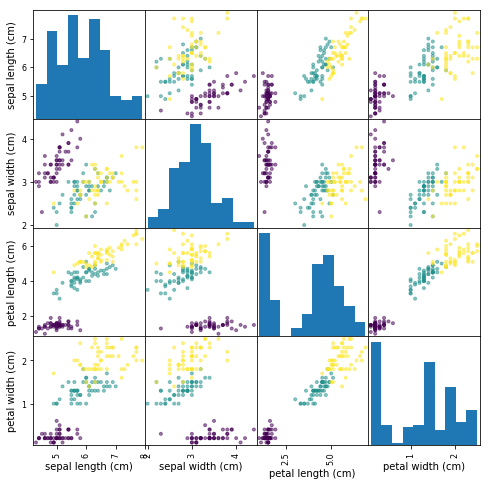

In [11]:
#ADD TITLE AND LEGEND
matplotlib.rcParams['figure.figsize'] = [8, 8]
pd.tools.plotting.scatter_matrix(iris_df, c = iris['target'], cmap = "viridis")
plt.show()

# Train Test Split of Data
As the dataset is relatively small, at only 150 observations, I'm going to sample 20 percent from each class, so that all classes are strongly represented in what will be a relatively small test set. 

In [20]:
train_data = pd.DataFrame()
train_labels = np.array([], dtype = int)
test_data = pd.DataFrame()
test_labels = np.array([], dtype = int)
for i in range(3):
    X = iris_df.loc[iris['target'] == i, ]
    y = [i]*X.shape[0]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
    train_data = pd.concat([train_data, X_train], ignore_index=True)
    train_labels = np.append(train_labels, y_train)
    test_data = pd.concat([test_data, X_test], ignore_index=True)
    test_labels = np.append(test_labels, y_test)

# SciKit Learn MLP Neural Network Implementation
The ultimate goal here is to reproduce the output of this function for a specific neural network. But we use SciKit Learn's MLP neural network function to figure out which network is going to be a relatively high performing one. 

In [21]:
n_nodes_per_layer = [20,100]#, 200]
n_folds = 10
data = []
for n_hidden_layers in range(1,4):
    for nodes in n_nodes_per_layer:
        structure = tuple([nodes]*n_hidden_layers)
        nn = MLPClassifier(hidden_layer_sizes=structure, solver = "sgd", 
                           max_iter = 1500, activation = "logistic", learning_rate = "constant")
        start_time = time.time()
        scores = cross_val_score(nn, train_data, train_labels, cv=n_folds)
        end_time = time.time()
        nn.fit(train_data, train_labels)
        test_set_accuracy = nn.score(test_data, test_labels)
        row = [structure, round(scores.mean(), 4), round(scores.std(), 4), 
               round(test_set_accuracy,4), round(end_time - start_time, 4)]
        data += [row]
        
results_df_nn = pd.DataFrame(data, columns = ["NN Structure", "CV Accuracy", "CV SD", "Test Set Accuracy","Fit Time"])
results_df_nn.sort_values(by = ["CV Accuracy", "CV SD", "Fit Time"], ascending = [False, True, True])

,NN Structure,CV Accuracy,CV SD,Test Set Accuracy,Fit Time
1,"(100,)",0.9667,0.0553,0.9667,7.7006
0,"(20,)",0.9167,0.0645,0.9000,4.8500
2,"(20, 20)",0.3667,0.1000,0.3333,0.2969
5,"(100, 100, 100)",0.3417,0.0250,0.3333,0.5677
4,"(20, 20, 20)",0.3250,0.0250,0.3333,0.4299
3,"(100, 100)",0.3167,0.2034,0.3333,0.3658


# Compare to SVM
It would seem the SVM performs better than the neural network when the neural network is trained using SGD. When we switch the minimization approach to adam or lbfgs though, the performance of the neural network and SVM are comparable. 

In [22]:
n_folds = 10
cs = [0.1, 1, 10,100]
gammas = [0.1, 1, 10,100]
kernels = ["rbf", "linear", "poly"]
data = []
for c in cs:
    for g in gammas: 
        for k in kernels:
            svmm = SVC(C = c, gamma = g, kernel = k)
            start_time = time.time()
            scores = cross_val_score(svmm, train_data, train_labels, cv=n_folds)
            end_time = time.time()
            svmm.fit(train_data, train_labels)
            test_set_accuracy = svmm.score(test_data, test_labels)
            row = [c,g,k, round(scores.mean(), 4), round(scores.std(), 4), 
                   round(test_set_accuracy,4), round(end_time - start_time,4)]
            data += [row]

results_df = pd.DataFrame(data, columns = ["C", "gamma", "Kernel", "CV Accuracy", "CV SD", 
                                           "Test Set Accuracy", "Fit Time"])
results_df = results_df.sort_values(by = ["CV Accuracy", "CV SD", "Fit Time"], ascending = [False, True, True])
results_df.head()

,C,gamma,Kernel,CV Accuracy,CV SD,Test Set Accuracy,Fit Time
22,1.0,100.0,linear,0.9833,0.0333,0.9667,0.0282
13,1.0,0.1,linear,0.9833,0.0333,0.9667,0.0283
24,10.0,0.1,rbf,0.9833,0.0333,0.9667,0.0323
19,1.0,10.0,linear,0.9833,0.0333,0.9667,0.0357
16,1.0,1.0,linear,0.9833,0.0333,0.9667,0.0384


# Implementation of an MLP Feed Forward Neural Network
We note that the neural network of a single layer with 100 nodes in a single layer is consistently the best performer (by cross validated accuracy on the training set) when updating weights by stochastic gradient descent in the scikit learn package. So, below I'm going to implement a neural network of that size from scratch. Hopefully it works. Fingers crossed.   

So I'm going to make a fully connected Neural Network, 4 inputs for petal length, petal width, sepal length & sepal width. Hidden layer of size 100, and finally a single output, set by the softmax function. We take a maximum likelihood, rather than a bayesian approach to determine the weights.  

The likelihood function we're trying to minimize is based on a multinomial distribution where the total number of trials is fixed at 1. 

$$
\begin{align}
L  &= \prod_{i =1}^{N} \binom{n}{y_{1i}, ..., y_{ki}} p_1^{y_{1i}}p_2^{y_{2i}}...p_k^{y_{ki}}, \quad \sum_{j=1}^{k} p_j = 1, \sum_{j=1}^{k} y_{ji} = n = 1 \implies y_{ji} \in \{0,1\} \\
&= \prod_{i =1}^{N} p_1^{y_{1i}}p_2^{y_{2i}}...p_k^{y_{ki}} \\
logL &= \sum_{i =1}^{N} \sum_{j = 1}^{k}y_{ji}log(p_j)
\end{align}
$$
$y_{ji}$ indicates that observation i is in class j if $y_{ji} = 1$ or observation i is not in class j if $y_{ji} = 0$  
$p_j$ is the probability of being classified in category j given the observed data, or $p_j = P(y_{j} = 1|x)$.  
So, basically we want to maximize our log likelihood, or minimize our negative log likelihood. The probabilities are a function of our weights, and so we select weights that optimize this function.  

### Derivation of Relevant Derivatives Used In Backprop
$$
\begin{align}
a_j &= \sum_{i}w_{ji}z_i\\
y_k &= \frac{exp(a_k)}{\sum_{j=1}^{K}exp(a_j)} \\
E(w) &= - \sum_{n=1}^{N} \sum_{k=1}^{K} t_{nk}log\ y_k(x_n, w) \\
E_n(w) &=  -\sum_{k=1}^{K} t_{k}log y_k(x, w)  = -\sum_{k=1}^{K} t_{k}[a_k - log(\sum_j exp(a_j))]\\
w_{ji} &= w_{ji} - \eta \frac{\partial E}{\partial w_{ji}}= w_{ji} - \eta \sum_{n=1}^{N} \frac{\partial E_n}{\partial w_{ji}} \\
\frac{\partial E_n}{\partial w_{ji}} &= \frac{\partial E_n}{\partial a_j}\frac{\partial a_j}{\partial w_{ji}} = -(t_j - \frac{exp(a_j)}{\sum_s exp(a_s)}) = (y_j - t_j)z_i \quad \text{Softmax Layer Update}
\end{align}
$$

The update process propogates backwards, so we first get the weight update at the softmax level, then we move on to the first level. The issue here is that the activations $a_j$ are no longer directly accessible, and are instead only present as $z_j = \sigma(a_j)$ assuming a logistic sigmoid function is used, so this adds an extra layer of difficulty to the derivative. 

$$
\begin{align}
\frac{\partial E_n}{\partial w_{ji}} &= \frac{\partial E_n}{\partial a_j}\frac{\partial a_j}{\partial w_{ji}} = \frac{\partial E_n}{\partial a_j} z_i \\
&= \frac{\partial E_n}{\partial z_j} \frac{\partial z_j}{\partial a_j}z_i, \quad \frac{\partial z_j}{\partial a_j} = \sigma(a_j)(1-\sigma(a_j)) = z_j(1-z_j) \\
&= \frac{\partial E_n}{\partial z_j}z_j(1-z_j)z_i \\
&= \bigg(\sum_{k \in U_j}\frac{\partial E_n}{\partial a_k} \frac{\partial a_k}{\partial z_j}\bigg)z_j(1-z_j)z_i\\
&= \bigg(\sum_{k \in U_j}\frac{\partial E_n}{\partial a_k} w_{kj}\bigg)z_j(1-z_j)z_i
\end{align} 
$$
Where $U_j$ is the set of locations that use the value $z_j$. Implementing the above equations, we provide code for a single layer MLP neural network below. 


In [23]:
# one hidden layer multilayer perceptron neural network ground up implementation. 
class mlp_nn():
    
    def __init__(self, w1, w2):
        # w1 = weights from inputs to hidden layer
        # w2 = weights from hidden layer to outputs. 
        self.n_inputs = w1.shape[0]
        self.n_nodes = w1.shape[1]
        self.w1 = w1
        self.w2 = w2
                
    
    def predict(self, train_data, train_labels, confusion):
        n = train_data.shape[0]
        labels = pd.get_dummies(train_labels)
        predictions = [0]*n
        
        for i in range(n):
            t = labels.iloc[i]
            tdi = train_data.iloc[i].values
            activations_layer1 = np.matmul(tdi, self.w1)
            z_layer1 = 1.0/(1.0 + np.exp(-1.0*activations_layer1)) #logistic transformation
            activations_layer2 = np.matmul(self.w2, z_layer1)
            y = np.exp(activations_layer2)/np.sum(np.exp(activations_layer2)) #softmax
            predictions[i] = np.argmax(y)
            
        A = np.mean(predictions == train_labels)
        if confusion:
            print confusion_matrix(train_labels, predictions)
            
        return A

    
    def fit(self, train_data, train_labels, plot, n_epochs, eta = .01):
        # backprop for gradient descent. 
        labels = pd.get_dummies(train_labels)
        l2_shape = self.w2.shape
        l1_shape = self.w1.shape
        n = train_data.shape[0]
        E = [0]*n_epochs
        A = [0]*n_epochs
        for ep in range(n_epochs):
            # iterate through every point in the train dataset
            for i in range(n): 
                
                #get labels & train_data
                t = labels.iloc[i]
                tdi = train_data.iloc[i].values
                
                #forward step
                activations_layer1 = np.matmul(tdi, self.w1)
                z_layer1 = 1.0/(1.0 + np.exp(-1.0*activations_layer1)) #logistic transformation
                activations_layer2 = np.matmul(self.w2, z_layer1)
                y = np.exp(activations_layer2)/np.sum(np.exp(activations_layer2)) #softmax
                
                # get update to second layer weights 
                l2_weight_update = np.zeros(l2_shape)
                for j in range(l2_shape[0]):
                    for k in range(l2_shape[1]):
                        l2_weight_update[j][k] = (y[j] - t[j])*z_layer1[k]
                
                # get update to first layer weights
                l1_weight_update = np.zeros(l1_shape)
                for l in range(l1_shape[0]):
                    for m in range(l1_shape[1]):
                        x = 0.0
                        for p in range(l2_shape[0]):
                            x += (y[p] - t[p]) * w2[p][m]
                        l1_weight_update[l][m] = tdi[l] * z_layer1[m] * (1 - z_layer1[m]) * x
                        
                #update weights
                self.w1 -= eta * l1_weight_update
                self.w2 -= eta * l2_weight_update
                
                #Update Errors 
                E[ep] -= np.sum(t * np.log(y))
            
            
            # Update Accuracy
            A[ep] = self.predict(train_data, train_labels, confusion = False)
            
            #print "Epoch {} Completed".format(ep)
        
        if plot:
            fig, (ax0, ax1) = plt.subplots(ncols=2, figsize = (20, 10))
            
            ax0.plot(range(1,n_epochs+1), E)
            ax0.set_ylabel('Error')
            ax0.set_xlabel("Epoch")
            ax0.set_title("E(w)")
            
            ax1.plot(range(1, n_epochs + 1), A)
            ax1.set_title("Training Set Accuracy, Max accuracy = {}".format(round(A[-1], 3)))
            ax1.set_xlabel("Epoch")
            ax1.set_ylabel("Accuracy")
            plt.show()



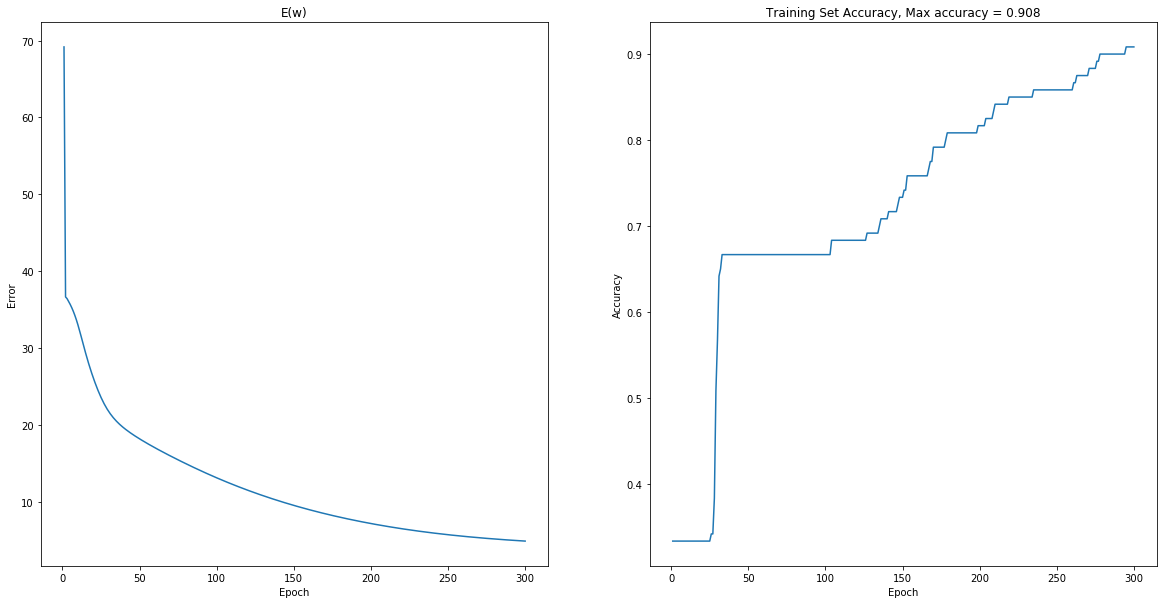

In [24]:
w1 = np.random.rand(4,100)
w2 = np.random.rand(3,100)
nn = mlp_nn(w1, w2)
nn.fit(train_data, train_labels, plot = True, n_epochs= 300)

In [26]:
nn.predict(test_data, test_labels, confusion = True)

[[10  0  0]
 [ 0  8  2]
 [ 0  0 10]]


0.93333333333333335

## Discussion of Results
While we don't quite get the 93% training accuracy that the sklearn function does, we do get 86% which isn't too bad. 